In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from category_encoders.one_hot import OneHotEncoder
# from sklearn.preprocessing import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# import dtale
# from pandas_profiling import ProfileReport
from datetime import datetime
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.preprocessing import OrdinalEncoder

In [11]:
X = pd.read_csv("train.csv", index_col="Id")
X_t = pd.read_csv("test.csv",index_col="Id")
Xdata = X.copy()
X_tdata = X_t.copy()
Xdata.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Missing value related problems

### We can see that some of the columns nearly have all the values are missing or zero.

- **ex:** *PoolQC and MiscFeature (Alley and Fence can also be include in this category)*
- **ex:** *LowQualFinSF, 3SsnPorch, PoolArea and MiscVal* (zero values)
- *(BsmtHalfBath, ScreenPorch, BsmtFinSF2 and EnclosedPorch can also be include in this category)*

*so we can drop these columns directly(precaution: before doing this check mi_score also).*
### important notes:
- LotFrontage is a  Linear feet of street connected to property missing values of this column can be of various reasons:
-- no Linear part of street connected to the property, 
-- some values are missed out while data is entered in dataset,
## columns types
- total columns: 80: 79 for input and 1 for output
- 3 columns of type float have missing values: LotFrontage, MasVnrArea, GarageYrBlt
- 16 columns of object (i.e. string here) data type have missing values ( 4 are considerable for removal)
#### remaining columns:
- 22 columns of int type have 0 values (4 are considerable to remove and 4 more less considerable are also there)
- 38 columns are also there( 11 int type and 27 object type)
- 1 output SalePrice is of int type

In [12]:
# code for observation
# imputation method
def missing_value_fill(temp):
    missing_features = [col for col in temp.columns if temp[col].isnull().any()]
    # features_non_zero_imputation = ["LotFrontage"] # ,"MasVnrArea","MasVnrType"
    #low_mi_score_features = ["PoolArea",LotFrontage,"MiscFeature","Alley","Fence","MasVnrArea","MasVnrType"]
    #selected_missing_features = set(missing_features)-set(features_non_zero_imputation)
    zero_imputed_feature = temp[missing_features].select_dtypes("number")
    none_imputed_feature = temp[missing_features].select_dtypes("category")
    none_na_feature = ["BsmtQual", "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond", 
                       "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageFinish","Fence"]
    sell_month_year = ["MoSold","YrSold"]
    mean_set = ['LotFrontage', 'LotArea', 'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GrLivArea']
    # zero imputed features : ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','PoolArea']
    # zero value exits :["KitchenAbvGr","FullBath","HalfBath","Fireplaces","LowQualFinSF",'WoodDeckSF', 
    # 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']
    for name in zero_imputed_feature:
        if name in mean_set:
            mean1 = temp[name].mean()
            temp[name] = temp[name].fillna(mean1)
        elif name in sell_month_year:
            val = temp[name].value_counts().index[0]
            temp[name] = temp[name].fillna(val)
        else:
            temp[name] = temp[name].fillna(0)    
    for name in none_imputed_feature:
        if name in none_na_feature:
            temp[name] = temp[name].fillna("None")
        else:
            val = temp[name].value_counts().index[0]
            temp[name] = temp[name].fillna(val)
    # temporal features        
    temporal_var = ["YearRemodAdd", 'GarageYrBlt']
    for col in temporal_var:
        temp[col] = np.where(temp[col]<temp.YearBuilt,temp.YearBuilt,temp[col])

#     frequent_set = ['MSSubClass', 'MSZoning', 'Street', 'Alley','LotShape', 'LandContour', 'Utilities', 'LotConfig', 
#                     'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 
#                     'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
#                     'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
#                     'KitchenQual', 'Functional', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']
    return temp

# Impute data related problems
1. PoolArea total 7 entries only so **columns can be droped** if data set is large(try after checking mi_score)
   - or can be **imputed by 0**
2. MiscVal is important compare to MiscFeature becoz it have values in dollar and directly contributing to price.
   - so MiscVal remains and MiscFeature column can be droped or **imputed by 0**(after checking mi_score)
3. Alley and Fence both columns can be removed (also check for mi_score)
   - or can be **imputed by 0**
4. FirePlaceQu **imputed by 0** for missing values as given
5. LotFrontage can be dependent on Street,LandContour, Condition1 and Condition2 by data obeservation:
    - most_fequent 60 can be imputed , 0 can be imputed, mean can be imputed
6. GarageType,GarageFinish,GarageQual and GarageCond are **imputed by 0**  because here missing values means no garage.
   (GarageType=65% Attchd,GarageFinish=unf 40%,GarageQual= 90% TA,GarageCond=90% TA,GarageCars=60% 2cars and GarageArea=473avg)
   
    - GarageYrBlt is imputed by year greater than YearBuilt of house so 
    -- impute by same year as YearBuilt (buit it contradicts with no GarageBuilt) or
    -- try imputed by 0 also. or Normalize this column to (0,1) range and then impute by 0
7. BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2 are **imputed by 0** because here missing values means no basement
   (BsmtQual TA=Gd=60%, BsmtCond=TA 90%, BsmtExposure=No 70%, BsmtFinType1 Unf=GLQ=30%, BsmtFinType2=Unf 90%, and TotalBsmtSF)
8. MasVnrArea and MasVnrType both columns have identical rows of missing values so
    - either both are imputed by 0 or most_frequent both are same here 0 for MasVnrArea and None for MasVnrType
    - mean value can also be imputed but not that impactful because entries are very less.
9. Electrical column have only 1 missing value row can be removed or **most frequent value can be imputed** which is SBrkr abvoe90% by direct assignment because only 1 entry is there.
10. large number of zero containing **columns can also be droped** if data set is very large (try after checking mi_score).
    - columns having more than 90% zeroes are : PoolArea,3SsnPorch,LowQualFinSF,MiscVal,BsmtHalfBath and ScreenPorch

# some data cleaning
[temp[col].unique() for col in [c for c in temp.select_dtypes(['O'])]]

observe the unique entries(by unique() method) in each Category columns; corrupted entries can be found(but for large data set it is slow process to check manually all this inconsistency).
- Neighborhood column: entry value NAmes; but actual given value is Names.
- BldgType column: entry value Duplx,TwnhsI; but actual given values are Duplex and Twnhs respectively.
- Exterior2nd column: entry value CemntBd,WdShing,BrkComm; but actual given values are CmentBd,Wd Shng and Brk Cmn respectively.

observe the impact and change corresponding values accordingly.

another way of finding this type of data inconsistency is by using fuzzywuzzy library and process and extract methods.




In [13]:
import fuzzywuzzy
from fuzzywuzzy import process
def percentage_matched_in_column(df, column, string_to_match):
    s1 = df[column].unique()
    display(fuzzywuzzy.process.extract(string_to_match,s1,limit=10,scorer = fuzzywuzzy.fuzz.token_sort_ratio))
# observe the required percentage for replacement and use following function to replace the matched string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)
    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    # let us know the function's done
    print("All done!")

C:\Users\shiva\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [15]:
# code for observation
# percentage check for inconsistent data 
dict1 = {"Neighborhood":'Names', "BldgType":['Duplx','TwnhsI'], "Exterior2nd":['CemntBd','WdShing','BrkComm']}
for k,v in dict1.items():
    if isinstance(v,list):
        for i in v:
            percentage_matched_in_column(temp,k,i)
    else:
        percentage_matched_in_column(temp,k,v)

In [16]:
# found out 1380 row number has missing value
Xdata.loc[1380,"Electrical"]='SBrkr'

In [17]:
# but label encoding required before impute method; because (0 or none)zero impute is done according to dtype
# encoding method
def encode(X,unordered_features,ordered_features):
    # Nominal categories
    for name in unordered_features:
        X[name] = X[name].astype("category")
        # Add a None category for missing values
        if "None" not in X[name].cat.categories:
            X[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_features["missing_v"].items():
        X[name] = X[name].astype(CategoricalDtype(levels,ordered=True))
    for name, levels in ordered_features["not_missing_v"].items():
        X[name] = X[name].astype(CategoricalDtype(levels,ordered=True))
    return X
# As we noticed by seeing shape.value_counts property 43 columns are of object type
# List of unordered categorical features{22 found by observation (21 object type and 1 integer type)}is:
unordered_features = ["Alley", "MasVnrType", "GarageType", "MiscFeature", "MSSubClass", "MSZoning", "Street", 
                      "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", 
                      "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "Foundation", "Heating", 
                      "SaleType", "SaleCondition"
                     ]
# MasVnrType: assume Nan also None
# MasVnrArea: Nan imputed by 0
# LotFrontage: 0 or avg or most_frequent
# The ordinal (ordered) categorical features{12 were given(10 object type and 2 integer type) and 12 were observed(object type)} are:
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(1,11))
ordered_features = {
                    "missing_v" : {
                                "BsmtQual": five_levels,
                                "BsmtCond": five_levels,
                                "FireplaceQu": five_levels,
                                "GarageQual": five_levels,
                                "GarageCond": five_levels,
                                "PoolQC": ["Fa", "TA", "Gd", "Ex"],
                                "BsmtExposure": ["No", "Mn", "Av", "Gd"],
                                "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                                "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                                "GarageFinish": ["Unf", "RFn", "Fin"],
                                "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"]
                                },
                    "not_missing_v" : {
                                "OverallQual": ten_levels,
                                "OverallCond": ten_levels,
                                "ExterQual": five_levels,
                                "ExterCond": five_levels,
                                "HeatingQC": five_levels,
                                "KitchenQual": five_levels,
                                "LotShape": ["IR3", "IR2", "IR1", "Reg"],
                                "Utilities": ["ELO","NoSeWa", "NoSewr", "AllPub"], # "NoSewr" and "ELO" are not present in our training data.
                                "LandSlope": ["Sev", "Mod", "Gtl"],
                                "CentralAir": ["N", "Y"],
                                "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
                                "Functional": ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
                                "PavedDrive": ["N", "P", "Y"]
                                }
                    }
# Add a None level for missing values
ordered_features["missing_v"] = {key: ["None"] + value for key, value in
                  ordered_features["missing_v"].items()}

In [18]:
temp_X = encode(Xdata,unordered_features,ordered_features)
temp_Xt = encode(X_tdata,unordered_features,ordered_features)

In [19]:
temp_X = missing_value_fill(temp_X)
temp_Xt = missing_value_fill(temp_Xt)

# Mutual regression:
- calculate mi scores and plot them and decide which features to drop (mostly with low mi scores)
-- but before droping any feature we have to check for intraction effect wiht another high mi socring feature using various plots or with the help of domain knowledge.

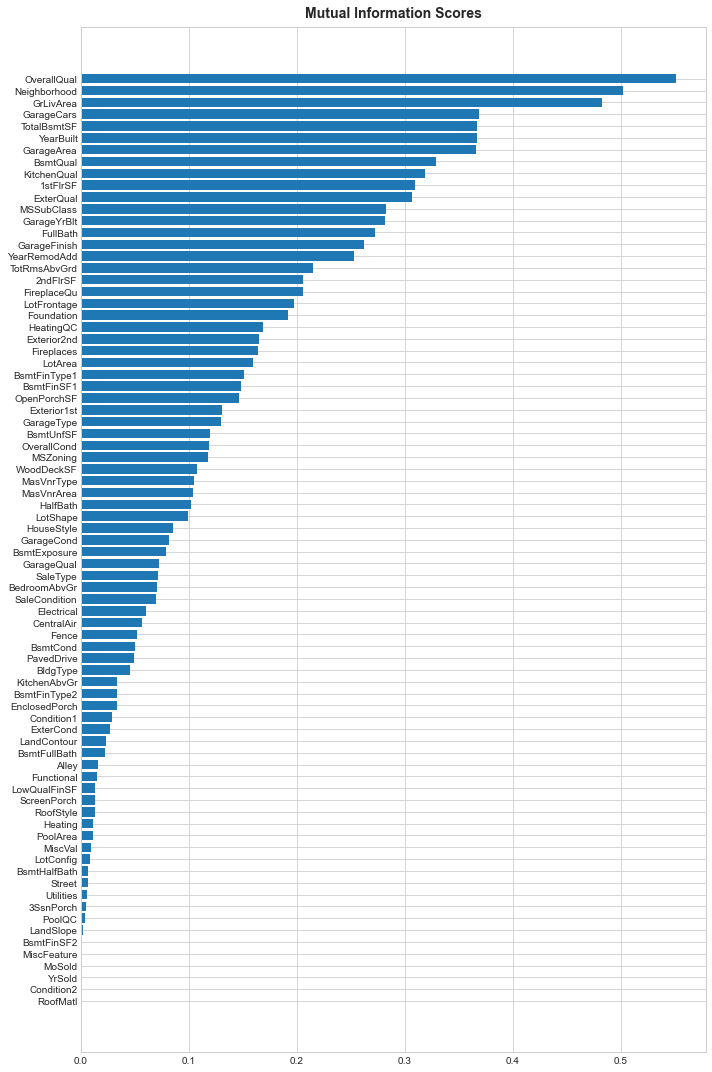

In [20]:
from sklearn.feature_selection import mutual_info_regression
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize() # it returns codes and uniques
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    discrete_features = X.dtypes == int # double check for discrete feature of integer type
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(figsize=(10,15))
mi_scores = make_mi_scores(temp_X.drop(labels=['SalePrice'],axis=1,),temp_X.SalePrice)
plot_mi_scores(mi_scores)

### Data visualisation

In [ ]:
# dtale.show(temp)

In [ ]:
# sns.lmplot(x="GrLivArea",y="SalePrice",data=temp,col="Neighborhood",col_wrap=4)

In [ ]:
# profile = ProfileReport(temp,title="Pandas Profiling Report",explorative=True)
# profile.to_file("house_prediction_data_report.html")
# profile = ProfileReport(temp, minimal=True)
# profile.to_file("house_prediction_data_report_minimal.html")

In [ ]:
# for col in ["PavedDrive","Street","Alley"]:
#     sns.lmplot(x="LotFrontage",y="SalePrice",data=temp,col=col,col_wrap=4)

In [ ]:
#1 we can use violin plot but use when less number of features are there and large data present to check for distribution
# fig, ax = plt.subplots(figsize=(15,6))
# sns.violinplot(x=temp.YrSold,y=temp.SalePrice,ax=ax,hue=temp.MoSold,scale="count",scale_hue=False)


# fig, ax = plt.subplots(figsize=(15,6))
# sns.boxplot(x=temp.YrSold,y=temp.SalePrice,hue=temp.MoSold)


#2 we can use swarm plot but use when less number of features are there and large data present to check for distribution
# fig, ax = plt.subplots(figsize=(10,6))
# sns.swarmplot(x=temp.YrSold,y=temp.SalePrice,ax=ax,size=3.6,hue=temp.MoSold,dodge=True)
#combination of box and swarm(or violin and swarm) plot can be use when 2 feature x and y are used (with hue it is not efficient)
# fig, ax = plt.subplots(figsize=(15,6))
# sns.boxplot(x=temp.YrSold,y=temp.SalePrice) / sns.violinplot(x=temp.YrSold,y=temp.SalePrice,scale='width')
# sns.swarmplot(x=temp.YrSold,y=temp.SalePrice,color='black',alpha=0.5)
# stripplot (this is used instead of swarmplot when data is large )
# scatter plot for releationship
# sns.scatterplot(x=temp.MoSold,y=temp.SalePrice,style=,hue=,size=,sizes=[,]) style,hue and size are used for 3rd feature
# sns.stripplot(x=temp.YrSold,y=temp.SalePrice,hue=temp.MoSold,dodge=True,jitter=0,alpha=0.8,size=10,marker="*")
# some other plots related to facetgrid
# fig, ax = plt.subplots(figsize=(15,6))
# sns.catplot(x="MoSold",y="SalePrice",col="YrSold",data=temp,sharex=False)
# sns.lmplot(x="YrSold",y="SalePrice",col="Neighborhood",data=temp,col_wrap=5)

In [ ]:
# sns.pairplot(temp.loc[:,"LotShape":"SaleCondition"])
# sns.lmplot("GrLivArea","SalePrice",data=temp,hue="BldgType",col = "BldgType")
# sns.lmplot("LotArea","SalePrice",data=temp,hue="LotShape",col = "LotShape")
# for col in high_cardinality_cols:
#     sns.catplot(x=col,y="SalePrice",data=temp,aspect=3,kind='box')

In [21]:
def find_missing(Xdata):
    """
    Xdata: dataframe
    return sorted missing values columns of given dataset.
    """ 
    from IPython.display import display
    missing_values_columns = [[col,Xdata[col].isnull().sum(),Xdata[col].dtypes] for col in Xdata.columns if Xdata[col].isnull().any()]
    display(sorted(missing_values_columns, key=(lambda k:k[1])),len(missing_values_columns))
def find_zerocolumns(Xdata):
    """
    Xdata: dataframe
    return sorted zero values columns of given dataset.
    """
    zero_values_columns = [[col,
                           Xdata[col].value_counts()[0],
                           Xdata[col].dtypes
                           ] 
                          for col in Xdata.columns 
                          if (0 in Xdata[col].value_counts().index)
                          ]
    display(sorted(zero_values_columns, key=(lambda k:k[1])),len(zero_values_columns))
def drop_uninformative(X, mi_scores,min_mi_score):
    """
    returns dataframe with low mi_scorer features removed
    
    X: dataframe 
    mi_score: mi_score list of all features
    min_mi_score: minimum score less than or equal to which are removed
    """
    low_mi = [col for col in mi_scores.index if mi_scores[col] <= min_mi_score]
    return X.drop(labels=low_mi,axis=1),low_mi
# Function for comparing different approaches
def cat_numeric_interaction(df,f1,f2,pref="inter_c_n"):
    """
    return a dataframe showing the interaction of f2 with each feature of f1
    
    df: dataframe (training dataset)
    f1: "str" category feature
    f2: "str" numerical feature
    pref: prefix for new columns
    """
    X = pd.get_dummies(df[f1], prefix=pref,drop_first=True)
    X = X.mul(df[f2], axis=0)
    return X
def cat_interaction(df,f1,f2,pref="inter_c"):
    """
    return a dataframe showing the interaction of f2 with each feature of f1
    
    df: dataframe (training dataset)
    f1,f2: "str" both category features
    pref: prefix for new columns
    """
    X = pd.get_dummies(df[f1], prefix=pref)
    X2 = pd.get_dummies(df[f2], prefix=pref)
    X = X.mul(X2, axis=0)
    return X
def add_features(df,f_list,new_feature):
    """
    df: dataframe
    f_list: list; feature list whose sum is needed
    new_feature: str, name of updated feature
    
    return dataset with updated feature
    """
    df[new_feature] = df[f_list].gt(0.0).sum(axis=1)
    return df

def break_down(df,n_f,s_f):
    """
    return updated dataframe with new splited feature
    
    df: dataframe (training dataset)
    n_f: str, new feature name 
    s_f: str, feature whose split needs to be done.
    """
    X = pd.DataFrame()
    X[n_f] = df[s_f].str.split("_", n=1, expand=True)[0]
    return X
def cluster_labels(df, features, n_clusters=20):
    """
    df: dataframe 
    features: list of features required for clustering
    n_clusters: int, number of clusters required
    
    returns the updated data set with clustering featuer
    """
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X["Cluster"] = kmeans.fit_predict(X_scaled)
    return X
def cluster_distance(df, features, n_clusters=20):
    """
    df: dataframe 
    features: list of features required for clustering
    n_clusters: int, number of clusters required
    
    returns the updated data set with clustering featuer
    """
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd
def apply_pca(X, size, standardize=True):
    """
    X: Dataframe
    size: number of components , put X.shape[1] if no reduction needed
    standardize: default True; False if scaling not required
    
    returns pca object, pca dataframe with mentioned features i.e. required data_set, loadings dataframe
    """
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA(n_components=size)
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

def pca_components(df, features):
    """
    df: dataframe
    feature: list of features required for pca
    
    returns pca dataframe with mentioned features
    """
    
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

In [22]:
# temp1, l_m = drop_uninformative(temp,mi_scores=mi_scores,min_mi_score=0)
# l_m
# temp = pd.concat([temp_X.drop(labels="SalePrice",axis=1),temp_Xt])
temp_X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,None,None,Shed,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0,None,None,Shed,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,None,None,Shed,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,None,None,Shed,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0,None,None,Shed,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,None,None,Shed,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,Shed,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500


# score for training data 
- apply one-hot encoding and ordinal encoding for ordered and unordered features respectively
- total 80 features 46 categorical (22 unordered and 24 ordered) remaining 34 numerical features

In [23]:
o_l = list(ordered_features['missing_v'].keys()) + list(ordered_features['not_missing_v'].keys())

In [24]:
drop_label = ["SalePrice","PoolQC","Utilities","Condition2","RoofMatl","MiscFeature","Street","Heating",]

In [25]:
Xt_train,Xt_valid,yt_train,yt_valid = train_test_split(temp_X.drop(labels=drop_label,axis=1,),temp_X.SalePrice, train_size=0.8, test_size=0.2, random_state=0)
#score with category features
# Make copy to avoid changing original data 
label_X_train = Xt_train.copy()
label_X_valid = Xt_valid.copy()

In [26]:
# remove already ordered features
o_l.remove("OverallQual")
o_l.remove("OverallCond")
o_l.remove("PoolQC")
o_l.remove("Utilities")

In [27]:
unordered_features.remove("Condition2")
unordered_features.remove("RoofMatl")
unordered_features.remove("MiscFeature")
unordered_features.remove("Street")
unordered_features.remove("Heating")

In [28]:
# Apply ordinal encoder to each column with ordered categorical data
ordinal_encoder = OrdinalEncoder(cols=o_l)#,mapping=mapping
label_X_train = ordinal_encoder.fit_transform(Xt_train)
label_X_valid = ordinal_encoder.transform(Xt_valid)

# nominal encoding:
- remove bad labeled columns 
- remove high cardinality columns or use ordinal encoding for them 

In [29]:
# some bad label columns must be removed because of them mismatch between training and validation data occurs.
good_unordered_label_cols = [col for col in unordered_features if set(Xt_valid[col]).issubset(set(Xt_train[col]))]
bad_unordered_label_cols = list(set(unordered_features)-set(good_unordered_label_cols))
bad_unordered_label_cols # 'Condition2', 'RoofMatl', 'MiscFeature' can be remove because mi score is also very less.
label_X_train.drop(labels=bad_unordered_label_cols,axis=1,inplace=True)
label_X_valid.drop(labels=bad_unordered_label_cols,axis=1,inplace=True)
# label_X_train has now 76 features

In [30]:
#low cardinality columns
low_cardinality_cols = [col for col in good_unordered_label_cols if label_X_train[col].nunique() < 30]
# Columns that will be dropped from the dataset or can do ordinal encoding again for these high cardinality columns
high_cardinality_cols = list(set(good_unordered_label_cols)-set(low_cardinality_cols))
onehot_encoder = OneHotEncoder(cols=low_cardinality_cols)
num_X_train = onehot_encoder.fit_transform(label_X_train)
num_X_valid = onehot_encoder.transform(label_X_valid)

# hyperparameter tuning

In [31]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt','log2']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10,14]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4,6,8]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#               'criterion':['entropy','gini']}

# rf=RandomForestRegressor()
# rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
#                                random_state=100,n_jobs=-1)
# ### fit the randomized model
# rf_randomcv.fit(X_train,y_train)
# def timer(start_time=None):
#     if not start_time:
#         start_time = datetime.now()
#         return start_time
#     elif start_time:
#         thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#         tmin, tsec = divmod(temp_sec, 60)
#         print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
# model = XGBRegressor()
# random_search=RandomizedSearchCV(model,param_distributions=params,n_iter=10,cv=2,scoring='roc_auc',n_jobs=-1,verbose=3)

# Scoring methods:

In [32]:

def score_dataset_simple(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)
def score_dataset_cross_val_sqrt(X, y, model=XGBRegressor(),fit_params = None):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    
#     for colname in X[o_l].select_dtypes(["category"]):
#         X[colname] = X[colname].cat.codes
    
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",fit_params=fit_params
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score
# we can specify our model
def score_dataset_cross_val(X, y, model=XGBRegressor()):
    """ 
    X: training dataframe or series for input
    y: training dataframe or series for target
    model: any defined regression model: initial parameters must already be assigned before passing here
    param_fit: fit parameters(in dictionary format) for defined model
        example: {"parameter_name1":"value","parameter_name2": constant_value}
    """
    # Label encoding for categoricals
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
#     cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    score = cross_val_score(
                            model, X, y, cv=5, scoring="neg_mean_absolute_error",
#                             fit_params={"early_stopping_rounds":10, "eval_set": [(x_valid, y_valid)]}
                            )
    score = -1 * score.mean()
    # score = np.sqrt(score)
    return score
def score_dataset_nn(X_train,X_valid,y_train,y_valid,e=50,i1=512,i2=256,i3=128,i4=64):
    early_stopping = EarlyStopping(min_delta=0.001,patience=10,
                               restore_best_weights=True)

    # Now run this cell to train the model and get the learning curves. 
    # Notice the callbacks argument in model.fit.
    input_shape = X_train.shape[1]
    model = keras.Sequential([
        layers.Dense(i1, activation='relu', input_shape=[input_shape]),
        layers.Dense(i2, activation='relu'),    
        layers.Dense(i3, activation='relu'),
        layers.Dense(i4, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mae',
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=512,
        epochs=e,
        callbacks=[early_stopping]#, steps_per_epoch=5
    )
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));
def score_dataset_nn_dropout_normalization(X_train,X_valid,y_train,y_valid):
    input_shape = X_train.shape[1]
    model = keras.Sequential([
        layers.BatchNormalization(input_shape=[input_shape]),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1),
    ])
    model.compile(
        optimizer='sgd',
        loss='mae',
        metrics=['mae'],
    )
    EPOCHS = 100
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=64,
        epochs=EPOCHS,
        verbose=0,
    )
    history_df = pd.DataFrame(history.history)
    history_df.loc[0:, ['loss', 'val_loss']].plot()
    print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

In [33]:
# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(num_X_train,yt_train)
# timer(start_time) # timing ends here for "start_time" variable

In [34]:
# random_search.best_estimator_,random_search.best_params_

In [38]:
model=XGBRegressor(n_estimators=500,learning_rate=0.05)

In [39]:
# model=random_search.best_estimator_
score_dataset_cross_val(num_X_train,yt_train,model=model)
# model.fit(num_X_train,yt_train)
# y_pre = model.predict(num_X_valid)

<IPython.core.display.Javascript object>

15839.107923593343

# feature engineering:


In [40]:
num_X_train = add_features(num_X_train,["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"],"Bsmtoverall")
num_X_valid = add_features(num_X_valid,["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"],"Bsmtoverall") 

In [41]:
num_X_train = add_features(num_X_train,["OpenPorchSF","EnclosedPorch","ScreenPorch","3SsnPorch","WoodDeckSF"],"TotalPorch")
num_X_valid = add_features(num_X_valid,["OpenPorchSF","EnclosedPorch","ScreenPorch","3SsnPorch","WoodDeckSF"],"TotalPorch")

In [42]:
num_X_train["LivLotRatio"] = num_X_train.GrLivArea / num_X_train.LotArea
num_X_train["Spaciousness"] = (num_X_train["1stFlrSF"] + num_X_train["2ndFlrSF"]) / num_X_train.TotRmsAbvGrd

In [43]:
num_X_train["Total_bath"] = num_X_train.FullBath + num_X_train.HalfBath + num_X_train.BsmtFullBath + num_X_train.BsmtHalfBath

In [45]:
num_X_train["MedNhbdArea"] = num_X_train.groupby("Neighborhood")["GrLivArea"].transform("median")

##### our model is trained now and work efficiently. but there is large scope of improvement.
~ 15800 is not a bad score but not that much good also.